In [1]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from kalman_filter_process import f_x, y_x
import numpy as np
import pandas as pd
import pylab
import random
from scipy.stats import describe

### Functions $f(x)$ and $y(x)$ from the paper

In [18]:
def f_x(state, dt):
    # constant for sampling time
    h = 2
    
    I_eff = state[0]
    G_s = state[1]
    R_a = state[2]
    R_a_neg_1 = state[3]
    p_1 = state[4]
    p_2 = state[5]
    p_4 = state[6]
    tau = state[7]

    # other required variables not part of the state
    w_k = np.random.normal(1)

    I_p = 0 + w_k
    C = 0 + w_k
    p_3 = 0 + w_k
    V = 0 + w_k # todo check for nonzero for V and value as 140

    # compute I_eff(k+1)
    component_1 = h * (p_2 * (I_eff/(h * p_2) - I_eff))
    component_2 = p_3 * I_p
    I_eff_next = component_1 + component_2

    # compute R_a(k+1)
    a = np.exp((h/tau))
    component_1 = (h * C) / (V * a * tau)
    component_2 = (2 * R_a) / a
    component_3 = R_a_neg_1 / a ** 2
    R_a_next = component_1 + component_2 - component_3

    # assuming G_b to be static for now have asked the prof whether this is fine.
    # todo otherwise the transition function will be time-dependent and that's way harder to implement.
    G_b = 100

    # computing G_s(k+1)
    component_1 = p_1 * (G_b + (G_s / (h * p_1)) - G_s)
    component_2 = p_2 * I_eff * G_s
    component_3 = R_a
    G_s_next = h * (component_1 - component_2 + component_3)

    # remaining variables for the next state
    R_a_neg_1_next = R_a
    p_1_next = p_1
    p_2_next = p_2
    p_4_next = p_4
    tau_next = tau

    next_state = [
        I_eff_next,
        G_s_next,
        R_a_next,
        R_a_neg_1_next,
        p_1_next,
        p_2_next,
        p_4_next,
        tau_next
    ]
    return next_state


def y_x(state):
    # the observation function takes the state and returns the CGM value only because that's what we
    # actually measure
    G_s = state[1]
    return np.array([G_s])

### Read in the meal data

In [19]:
cgm_to_meal = pd.read_csv('data/cgm_to_meal_start.csv')
cgm_to_meal = cgm_to_meal.dropna()
cgm = cgm_to_meal['cgm'].to_numpy()

In [20]:
print(cgm)

[314. 314. 314. ... 118. 118. 118.]


### Get the training points

In [21]:
TRAIN_POINTS = 500
START_INDEX = 1249
train = cgm[START_INDEX:START_INDEX + TRAIN_POINTS]

### Prepare Kalman Filter inputs

In [22]:
dt = 0.1 # time between samples
points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0) # sigma points
kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=points)

# remaining inputs are taken directly from the paper
kf.x = np.array([0, cgm[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
kf.R = np.array([100])
kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

### Run the kalman filter predict and update loop, and output predictions at every step

In [23]:
compare = []
for y in train[1:]:
    kf.predict()
    compare.append((kf.x[1], y))
    kf.update(y)
compare = np.array(compare)

### Predicted CGM vs measured CGM values

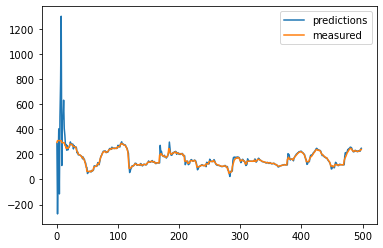

In [24]:
predictions = compare[:, 0]
measured = compare[:, 1]
pylab.plot(predictions, label='predictions')
pylab.plot(measured, label='measured')
pylab.legend()

# Thresholding

In [25]:
labels = cgm_to_meal['meal'].values[START_INDEX:START_INDEX + TRAIN_POINTS]


In [43]:

meal_start_indices = cgm_to_meal.loc[cgm_to_meal['meal_start']==1].index.tolist()
meal_30_indices = cgm_to_meal.loc[cgm_to_meal['meal']==1].index.tolist()
meal_indices = np.concatenate((meal_start_indices,meal_30_indices),axis=0).tolist()

non_meal_indices = cgm_to_meal.loc[(cgm_to_meal['meal']==0) & (cgm_to_meal['meal_start']==0) ].index.tolist()
# non_meal_30_indices = cgm_to_meal.loc[cgm_to_meal['meal_start']==0].index.tolist()
# non_meal_indices = np.concatenate((non_meal_start_indices,non_meal_30_indices),axis=0).tolist()

NUM_POINTS_MEAL = 800
NUM_POINTS_NON_MEAL = 1500

NUM_POINTS = 300

meal_indices_random = random.sample(meal_indices, NUM_POINTS_MEAL)
non_meal_indices_random = random.sample(non_meal_indices, NUM_POINTS_NON_MEAL)
D = [(meal_indices_random,'1'),(non_meal_indices_random,'0')]

prediction_array_meal = []
prediction_array_non_meal = []

for d in D:
    print(d[1])
    for idx in d[0]:
        if(idx >= NUM_POINTS):
            startIndex = idx - NUM_POINTS
            non_meal_points = cgm_to_meal.loc[cgm_to_meal['meal']==0]
            non_meal_points = non_meal_points.loc[startIndex:idx].index
            train = cgm_to_meal['cgm'].loc[non_meal_points].values
        else:
            startIndex = 0
            non_meal_points = cgm_to_meal.loc[cgm_to_meal['meal']==0]
            non_meal_points = non_meal_points.loc[startIndex:idx].index
            train = cgm_to_meal['cgm'].loc[non_meal_points].values

        dt = 0.1 # time between samples
        points = MerweScaledSigmaPoints(8, alpha=1, beta=2, kappa=0) # sigma points
        kf = UnscentedKalmanFilter(dim_x=8, dim_z=1, dt=dt, fx=f_x, hx=y_x, points=points)


        # remaining inputs are taken directly from the paper
        kf.x = np.array([0, train[0], 0, 0, 0.068, 0.037, 1.3, 20]) 
        kf.R = np.array([100])
        kf.Q = np.diag([1e-06, 1e-06, 1e-03, 1e-03, 1e-02, 1e-01, 1e-02, 1e-01])

        compare = []
        for y in train[1:]:
            try:
                kf.predict()
                compare.append((kf.x[1], y))
                kf.update(y)
            except Exception:
                pass
        compare = np.array(compare)
       
        try:
            kf.predict()
            meal_prediction = kf.x[1]
        except Exception:
            pass
    
        
        if(d[1] == '1'):
            prediction_array_meal.append((meal_prediction,cgm_to_meal['cgm'].loc[idx]))
        else:
            prediction_array_non_meal.append((meal_prediction,cgm_to_meal['cgm'].loc[idx]))



1
0


[210.592      120.35655443 477.23348817  -9.69759976 428.59863041
 100.98787102 260.85617469 181.92183251 332.84984454  92.35060383
 461.86827092 -59.8241081  411.36309439 -64.7393768  339.09955636
   8.93036675 281.27933591  60.41581539 164.29879845  60.45891631
 115.43723582  55.52785695 115.90039823  65.51091551 116.46003032
  86.76879927  49.60242884  62.93331567 143.53767241  73.68422359
  69.41371921  72.0298402   74.69178162  80.16027852  79.81389364
  76.76377662  79.86305584 120.33676231  93.3893566  131.45824887
 107.53842986  95.34382117 120.33536967 109.42595124 114.95747467
 110.53013748 115.4727314  124.36425788 138.43203746 139.21707597
 125.2705424  116.12682935 106.83143054 116.88417159 118.96928891
 123.15708895 123.32459698 123.53458401 124.52913796 129.39128517
 127.72141584 128.04642856 121.86827748 118.78554826 126.80359657
 131.35092055 137.07821892 149.95285257 142.5027896  142.61360667
 141.28359918 141.80811597 209.83258634 174.4719676  178.36049398
 174.79270

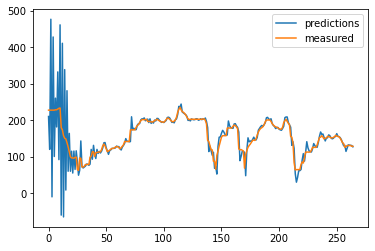

In [44]:
predictions = compare[:, 0]
measured = compare[:, 1]
pylab.plot(predictions[:-1], label='predictions')
pylab.plot(measured[:-1], label='measured')
pylab.legend()
print(predictions)

In [45]:
prediction_array_meal = [(x[0],x[1]) for x in prediction_array_meal if (x[0]<1000 and x[0]>0)]
prediction_array_non_meal = [(x[0],x[1]) for x in prediction_array_non_meal if (x[0]<1000 and x[0]>0)]
prediction_array_meal = np.array(prediction_array_meal)
prediction_array_non_meal = np.array(prediction_array_non_meal)
print(len(prediction_array_meal),np.mean(prediction_array_meal[:,0]))
print(len(prediction_array_non_meal),np.mean(prediction_array_non_meal[:,0]))

799 177.55818778413644
1495 161.33377632119522


In [46]:
prediction_array_non_meal.tolist()

[[118.66465535731012, 123.0],
 [165.40491471536018, 163.0],
 [119.23018557266761, 125.0],
 [117.21761445499953, 117.0],
 [115.38865947768127, 124.0],
 [180.04006608317422, 188.0],
 [209.3169305686984, 209.0],
 [51.206659186512894, 60.0],
 [106.26358890882076, 108.0],
 [205.92546814113388, 217.0],
 [92.07139863086735, 92.0],
 [226.30429720395728, 228.0],
 [305.1195960807336, 305.0],
 [270.2785761802388, 270.0],
 [128.45378173126866, 141.0],
 [149.81247725077077, 153.0],
 [234.90087976705752, 245.0],
 [160.0871285200438, 156.0],
 [123.2064608611139, 110.0],
 [190.39204928480763, 188.0],
 [286.5011165653151, 271.0],
 [126.56542318527784, 130.0],
 [90.70982124319985, 90.0],
 [228.69417425242887, 229.0],
 [174.40579787435945, 176.0],
 [307.5439973503469, 303.0],
 [182.88843024051266, 188.0],
 [239.1886424151001, 236.0],
 [260.47168243854617, 253.0],
 [102.68080009841736, 110.0],
 [77.9906170656657, 80.0],
 [223.20007254197697, 218.0],
 [212.82199846777786, 199.0],
 [150.65668271227514, 150.

In [47]:
residual_meal = []
for i in range(len(prediction_array_meal)):
    residual_meal.append(np.abs(prediction_array_meal[i][1]-prediction_array_meal[i][0]))
# residual_meal = np.array(residual_meal)
# meal_residual_mean = np.mean(residual_meal)

residual_non_meal = []
for i in range(len(prediction_array_non_meal)):
    residual_non_meal.append(np.abs(prediction_array_non_meal[i][1]-prediction_array_non_meal[i][0]))
# residual_non_meal = np.array(residual_non_meal)
# meal_residual_non_mean = np.mean(residual_non_meal)



In [48]:
describe(residual_meal)


DescribeResult(nobs=799, minmax=(0.01755845520619914, 497.2439014849065), mean=13.422138403323688, variance=570.1000040412757, skewness=11.504498142618727, kurtosis=212.76432068743952)

In [49]:
describe(residual_non_meal)

DescribeResult(nobs=1495, minmax=(0.003448248257996056, 242.34671585860417), mean=7.782442595713755, variance=178.8168595582869, skewness=7.67136541235484, kurtosis=99.65265645704639)

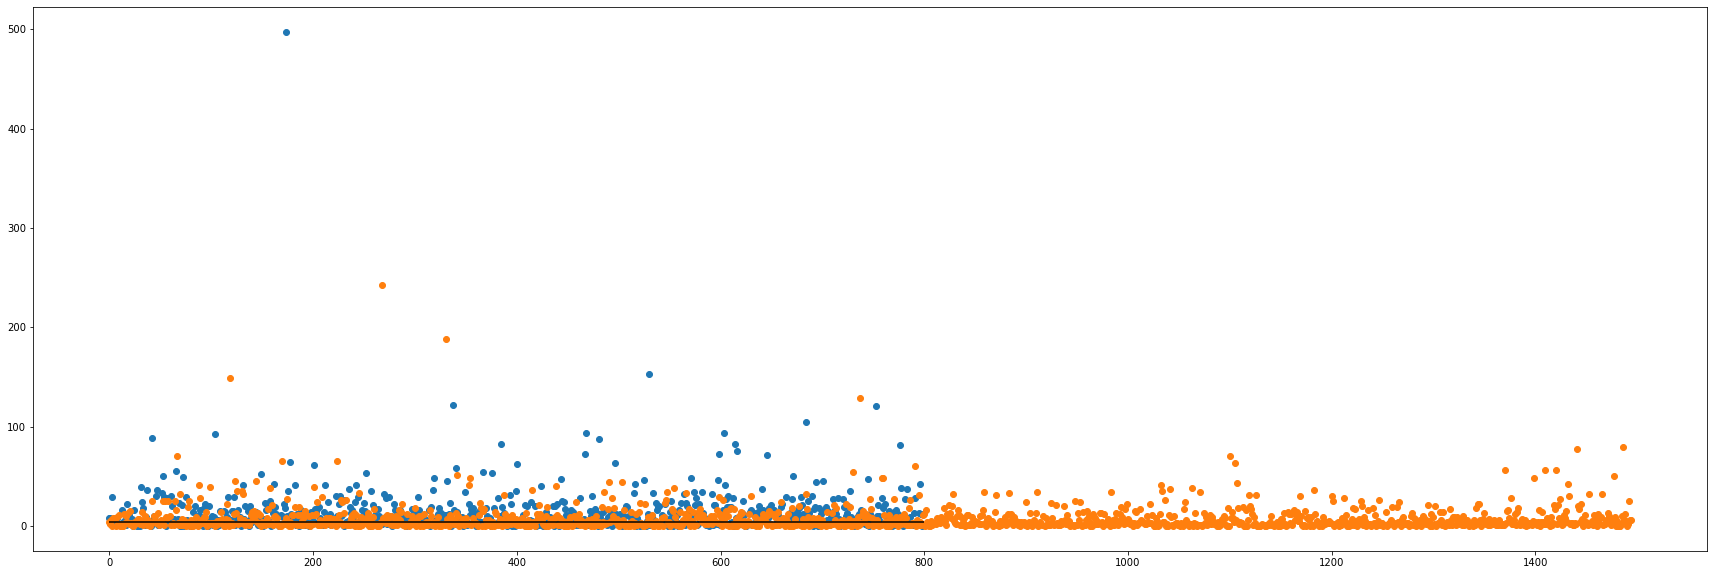

In [50]:
import matplotlib.pyplot as plt
x_meal = np.arange(0,len(residual_meal))
y_meal = np.array(residual_meal)
x_non_meal = np.arange(0,len(residual_non_meal))
y_non_meal = np.array(residual_non_meal)
plt.figure(figsize=(30, 10))
plt.scatter(x_meal,y_meal)
plt.scatter(x_non_meal,y_non_meal)
plt.hlines(4.5, 0, 800, color='black')

In [51]:
non_meal_diff = np.array(residual_non_meal)
meal_diff = np.array(residual_meal)

# Get Accuracy

In [ ]:
threshold = 50
non_meal_row = [non_meal_diff[non_meal_diff < threshold].__len__(), non_meal_diff[non_meal_diff >= threshold].__len__()]
meal_row = [meal_diff[meal_diff < threshold].__len__(), meal_diff[meal_diff >= threshold].__len__()]

true_positive = meal_diff[meal_diff >= threshold].__len__() / meal_diff.__len__()
true_negative = non_meal_diff[non_meal_diff < threshold].__len__() / non_meal_diff.__len__()

false_positive = non_meal_diff[non_meal_diff >= threshold].__len__() / non_meal_diff.__len__()
false_negative = meal_diff[meal_diff < threshold].__len__() / meal_diff.__len__()

print("TP ", true_positive, "FP ", false_positive, "TN ", true_negative, "FN ", false_negative)
print("accuracy: ", (non_meal_row[0] + meal_row[1]) / (non_meal_row[0] + meal_row[1] + non_meal_row[1] + meal_row[0]) )

TP  0.03629536921151439 FP  0.01137123745819398 TN  0.988628762541806 FN  0.9637046307884856
accuracy:  0.6569311246730601
